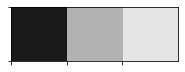

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import time
import warnings

%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning
warnings.filterwarnings('ignore')  # ignore all warnings

def set_style(font='seaborn-talk'):
    plt.style.use(['seaborn-white', font])
    matplotlib.rc("font", family="Times New Roman")

    
def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
#         [0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        [0.9, 0.9, 0.9],          # light gray
#         'red',
#         'black',
#         'blue'
    ])
        
        
def set_size(fig, w=6, h=3):
    fig.set_size_inches(w, h)
    plt.tight_layout()

    
sns.palplot(get_colors())

set_style()
sns.set_palette(np.array(get_colors()))

In [2]:
sns.set_palette(['red', 'black', 'blue'])

from sklearn.isotonic import IsotonicRegression


def log2(x):
    return np.log(x) / np.log(2)


# def log_lr_cost(lr, score_col):    
#     lr_same = np.exp(np.array(lr[score_col].loc[lr.a == lr.b], 
#                               dtype=np.float128))
#     lr_diff = np.exp(np.array(lr[score_col].loc[lr.a != lr.b], 
#                               dtype=np.float128))
#     return (2*len(lr_same))**-1 * np.sum(log2(1 + 1/(lr_same))) + \
#            (2*len(lr_diff))**-1 * np.sum(log2(1 + lr_diff))
# 
# print(round(log_lr_cost(oc_lr, 'lr_alpha_vary'),3))


def log_lr_cost(lr_same, lr_diff, neutral=False): 
    if neutral:
        lr_same = np.ones(len(lr_same))
        lr_diff = np.ones(len(lr_diff))
        
    return 0.5 * np.mean(log2(1 + 1/(lr_same))) + \
           0.5 * np.mean(log2(1 + lr_diff))


def calibrate(data, score_col):
    pava = IsotonicRegression().fit(
        X=np.array(data[score_col], dtype='float128'), 
        y=np.array(data['same-src'])
    )
    post_prob = pava.predict(data[score_col])

    n_s = sum(data['same-src'])
    n_d = len(data) - n_s
    post_log_odds = np.log(post_prob) - np.log(1-post_prob)
    prior_log_odds = np.log(n_s/n_d)
    
    return post_log_odds - prior_log_odds


def ece(lr_same, lr_diff, odds, neutral=False):
    if neutral:
        lr_same = np.ones(len(lr_same))
        lr_diff = np.ones(len(lr_diff))
#     s = ((odds/(1+odds))) * np.sum(log2(1 + 1/(lr_same*odds)))
#     d = ( (1/(1+odds))  ) * np.sum(log2(1 + lr_diff*odds))
#     return (s+d) / (len(lr_same) + len(lr_diff))
    return ((odds/(1+odds))) * np.mean(log2(1 + 1/(lr_same*odds))) + \
           ( (1/(1+odds))  ) * np.mean(log2(1 + lr_diff*odds))


def plot_ece(lr, score_col, rng=[-3,3], log_scale=True):
    ind_same = lr.a == lr.b
    ind_diff = lr.a != lr.b
    lr_same = np.array(lr[score_col].loc[ind_same], dtype=np.float128)
    lr_diff = np.array(lr[score_col].loc[ind_diff], dtype=np.float128)
    if log_scale:
        lr_same = np.exp(lr_same)
        lr_diff = np.exp(lr_diff)

    log_odds = np.arange(rng[0], rng[1], 0.01)
    odds = np.power(10, log_odds)
    
    # Neutral ECE -> LR = 1
    ece_neutral = [ece(lr_same, lr_diff, x, neutral=True) for x in odds]
    cllr_neutral = log_lr_cost(lr_same, lr_diff, neutral=True)

    # Empirical ECE
    ece_emp = [ece(lr_same, lr_diff, x) for x in odds]
    cllr_emp = log_lr_cost(lr_same, lr_diff)
    
    # PAV calibrated ECE
    lr_calibrated = calibrate(lr, score_col)
    lr_same = np.exp(np.array(lr_calibrated[ind_same], dtype=np.float128))
    lr_diff = np.exp(np.array(lr_calibrated[ind_diff], dtype=np.float128))
        
    ece_calibrated = [ece(lr_same, lr_diff, x) for x in odds]
    cllr_calibrated = log_lr_cost(lr_same, lr_diff)
    
    # make amenable for seaborn plotting
    lr_key = 'LR values, {}'.format(round(cllr_emp, 3))
    neutral_key = 'LR=1 always, {}'.format(round(cllr_neutral, 3))
    pav_key = 'PAV Calibrated, {}'.format(round(cllr_calibrated, 3))
    dat = pd.DataFrame({'log_odds': log_odds, 
                        lr_key: ece_emp, 
                        neutral_key: ece_neutral,
                        pav_key: ece_calibrated})
    dat = dat.melt('log_odds')
        
    f, ax = plt.subplots()

    ax = sns.lineplot(
        x='log_odds',
        y='value',
        style='variable',
        data=dat,
        hue='variable',
        lw=2
    )
    plt.axvline(0, color='Grey', linestyle='dotted')
    
    ax.set(ylabel="Empirical cross-entropy")
    ax.set(xlabel="$log_{10}$ $O(H_s|I)$")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    
    return f, ax

# Student Web Browsing Data

In [3]:
data_directory = os.path.join("..", "..", "thesis", "data")
plot_directory = os.path.join("figs", "temporal", "student_web_browsing")

browsing = pd.read_csv(os.path.join(data_directory, "student_web_browsing_slr.csv"))
browsing['same-src'] = (browsing.a == browsing.b).astype(bool)
browsing.head()

,a,b,iet_mn,iet_md,s,m,same-src
0,2,2,3.025308e+15,1.876839e+13,3.158077e+17,4.521514e+16,True
1,4,4,3.045875e+14,9.084513e+04,5.096204e+16,4.521514e+16,True
2,10,10,8.817127e+14,3.142483e+03,7.919797e+14,3.416272e+09,True
3,11,11,6.629888e+16,8.273711e+06,7.623582e+01,2.666592e-01,True
4,13,13,5.729002e+15,1.793316e+07,6.271003e+01,3.419754e+00,True


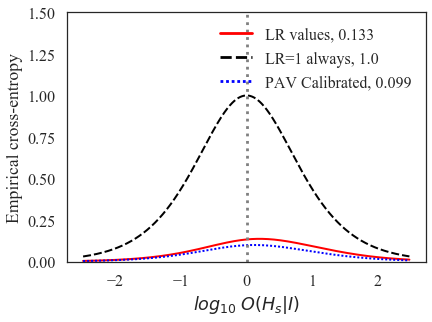

In [4]:
set_style(font='seaborn-poster')

ylim = (0, 1.5)

f, ax = plot_ece(browsing, 'iet_mn', rng=[-2.5,2.5], log_scale=False)
set_size(f, w=6, h=4.5)
plt.ylim(ylim)

plt.savefig(os.path.join(plot_directory, "ece_slr_iet_mn.eps"), dpi=500)

plt.show()

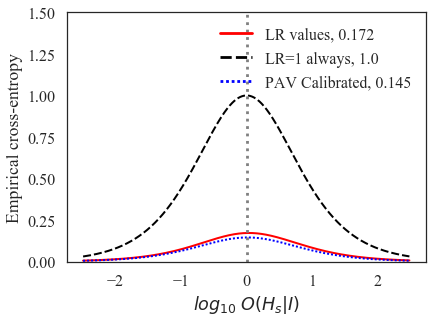

In [5]:
f, ax = plot_ece(browsing, 'iet_md', rng=[-2.5,2.5], log_scale=False)
set_size(f, w=6, h=4.5)
plt.ylim(ylim)

plt.savefig(os.path.join(plot_directory, "ece_slr_iet_md.eps"), dpi=500)

plt.show()

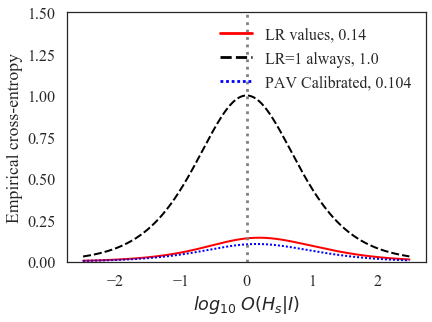

In [6]:
f, ax = plot_ece(browsing, 's', rng=[-2.5,2.5], log_scale=False)
set_size(f, w=6, h=4.5)
plt.ylim(ylim)

plt.savefig(os.path.join(plot_directory, "ece_slr_s.eps"), dpi=500)

plt.show()

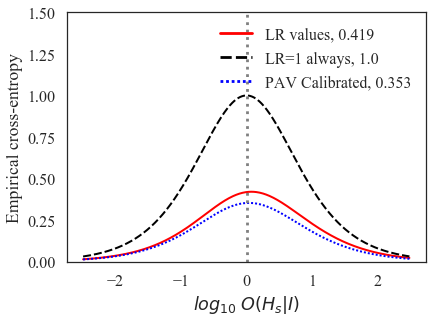

In [7]:
f, ax = plot_ece(browsing, 'm', rng=[-2.5,2.5], log_scale=False)
set_size(f, w=6, h=4.5)
plt.ylim(ylim)

plt.savefig(os.path.join(plot_directory, "ece_slr_m.eps"), dpi=500)

plt.show()

# Simulated Data

In [8]:
plot_directory = os.path.join("figs", "temporal", "simulation")

simulation = pd.read_csv(os.path.join(data_directory, "simulation_results.csv"))
simulation['same-src'] = ~(simulation.indep.astype(bool))
simulation['a'] = 1
simulation['b'] = 1
simulation.b.loc[simulation['same-src'] == False] = 2
simulation.head()

,r_mult,p,sigma,rate,iet_mn,iet_md,n_a,n_b,indep,slr_iet_mn,slr_iet_md,cmp_iet_mn,cmp_iet_md,snr,same-src,a,b
0,1,0.01,30,195.882630,0.000276,0.000180,1343,11,0,397.619958,195.736072,0.000706,0.000504,14.6,True,1,1
1,1,0.01,30,105.395201,0.000171,0.000122,718,6,0,574.137932,186.111795,0.000404,0.000303,14.6,True,1,1
2,1,0.01,30,290.566972,0.000307,0.000174,2025,14,0,347.633545,194.916662,0.000908,0.000504,14.6,True,1,1
3,1,0.01,30,105.195097,0.000238,0.000239,741,8,0,476.544026,149.740898,0.000504,0.001009,14.6,True,1,1
4,1,0.01,30,39.397618,0.000297,0.000303,291,5,0,362.394846,100.906888,0.000908,0.002119,14.6,True,1,1


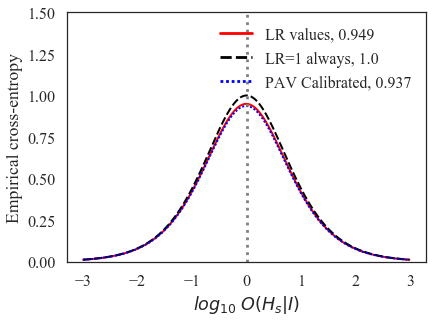

In [9]:
### low SNR
ind = (simulation.p == 0.20) & (simulation.snr == 0.073)

f, ax = plot_ece(simulation.loc[ind], 'slr_iet_mn', log_scale=False)
set_size(f, w=6, h=4.5)
plt.ylim(ylim)

plt.savefig(os.path.join(plot_directory, "ece_slr_iet_mn_low_snr.eps"), dpi=500)

plt.show()

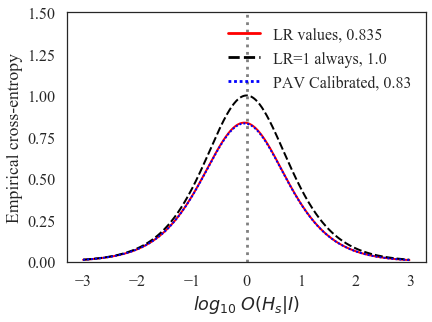

In [10]:
### med SNR
ind = (simulation.p == 0.20) & (simulation.snr == 0.73) & (simulation.r_mult == 1)

f, ax = plot_ece(simulation.loc[ind], 'slr_iet_mn', log_scale=False)
set_size(f, w=6, h=4.5)
plt.ylim(ylim)

plt.savefig(os.path.join(plot_directory, "ece_slr_iet_mn_med_snr.eps"), dpi=500)

plt.show()

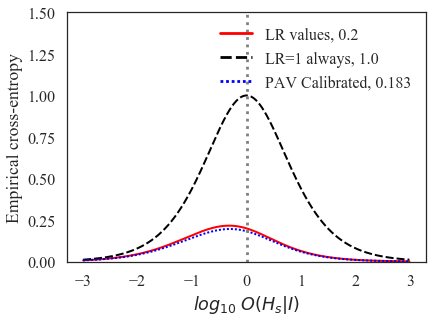

In [11]:
### high SNR
ind = (simulation.p == 0.20) & (simulation.snr == 3.65) & (simulation.r_mult == 1)

f, ax = plot_ece(simulation.loc[ind], 'slr_iet_mn', log_scale=False)
set_size(f, w=6, h=4.5)
plt.ylim(ylim)

plt.savefig(os.path.join(plot_directory, "ece_slr_iet_mn_high_snr.eps"), dpi=500)

plt.show()

# Population CMP for Students

In [12]:
from sklearn.metrics import roc_auc_score

def perf_measure(y_actual, y_hat):
    y_actual = list(y_actual)
    y_hat = list(y_hat)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    return (format(round(tpr, 3), '.3f'), format(round(fpr, 3), '.3f'))


def calc_auc(rslt, score, column='label'):
    return format(round(roc_auc_score(rslt[column], rslt[score]), 3), '.3f')


def cmp_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & TP@0.05  & TP@0.01 & AUC    ")
    print("\\hline")
    print(
        "& $S$     & ", 
        perf_measure(~rslt['label'], rslt['s'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['s'] < 0.001)[0], "  &",
        calc_auc(rslt, 's'), "\\\\"
    ) 
    print(
        "% & $\mean{M}_1$ & ",
        perf_measure(~rslt['label'], rslt['m'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['m'] < 0.001)[0], "  &",
        calc_auc(rslt, 'm'), "\\\\"
    )
    print(
        "& $\mean{\Tau}_{BA}$ & ", 
        perf_measure(~rslt['label'], rslt['iet_mn'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['iet_mn'] < 0.001)[0], "  &",
        calc_auc(rslt, 'iet_mn'), "\\\\"
    )
    print(
        "& $med(\Tau_{BA})$ & ", 
        perf_measure(~rslt['label'], rslt['iet_md'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['iet_md'] < 0.001)[0], "  &",
        calc_auc(rslt, 'iet_md'), "\\\\"
    )

    
    
def calc_cmp(df, uA, uB, score):
    val = df.loc[(df.a == uA) & (df.b == uB), score].to_numpy()
    diff = df.loc[
        (df.a != df.b) & ~(df.a.isin({uA, uB})) & ~(df.b.isin({uA, uB})), score
    ].to_numpy()
    
    if score == 'm':
        return sum(diff > val) / diff.shape[0]
    else:
        return sum(diff < val) / diff.shape[0]

In [13]:
### get the data
score_vals = pd.read_csv('~/dev/CSAFE/JRSSA_2020_final/data/student_web_browsing/scores.csv')
score_vals.columns = ['a', 'b', 'iet_mn', 'iet_md', 's', 'm']
score_vals.head()

,a,b,iet_mn,iet_md,s,m
0,2,2,0.000130,0.000046,-0.122646,0.259054
1,2,4,0.067831,0.003171,0.657295,0.063237
2,2,10,0.061136,0.002020,0.680425,0.037732
3,2,11,0.115432,0.000816,0.803584,0.007164
4,2,13,0.077090,0.005289,0.813711,0.021814


In [14]:
### test it
calc_cmp(df=score_vals, uA=2, uB=2, score='iet_mn')

0.0

In [15]:
# ### calc for all pairs
# scores= [
#     "iet_mn",
#     "iet_md",
#     "s",
#     "m"
# ]

# cmp_pop = []

# for index, row in score_vals.iterrows():
#     tmp_cmp = {"a": row["a"], "b": row["b"]}
    
#     for s in scores:
#         tmp_cmp[s] = calc_cmp(score_vals, row["a"], row["b"], s)

#     cmp_pop.append(tmp_cmp)
    
# cmp_pop = pd.DataFrame.from_dict(cmp_pop)
# cmp_pop.to_csv('~/Desktop/student_web_browsing_cmp_pop.csv', index=False)

cmp_pop = pd.read_csv('~/Desktop/student_web_browsing_cmp_pop.csv')
cmp_pop.head()

,a,b,iet_mn,iet_md,s,m
0,2.0,2.0,0.000000,0.000000,0.000000,0.000000
1,2.0,4.0,0.646952,0.093251,0.063135,0.223512
2,2.0,10.0,0.614296,0.046807,0.095428,0.469521
3,2.0,11.0,0.832003,0.006531,0.448113,0.966981
4,2.0,13.0,0.699202,0.181785,0.480044,0.715530


In [16]:
cmp_pop["same-src"] = (cmp_pop.a == cmp_pop.b).astype(bool)
cmp_pop['label'] = (cmp_pop.a != cmp_pop.b).astype(bool)
print("cmp_pop")
cmp_classifier_performance_for_tex(cmp_pop)

cmp_pop
& $\Delta$ & TP@0.05  & TP@0.01 & AUC    
\hline
& $S$     &  0.982   & 0.836   & 0.995 \\
% & $\mean{M}_1$ &  0.800   & 0.564   & 0.950 \\
& $\mean{\Tau}_{BA}$ &  0.982   & 0.891   & 0.996 \\
& $med(\Tau_{BA})$ &  0.945   & 0.855   & 0.992 \\


# Simulated CMP for Students

In [23]:
### get the data
cmp_same = pd.read_csv('~/dev/CSAFE/JRSSA_2020_final/data/student_web_browsing/thesis/cmp_n1e3_same_src_parallel.csv')
cmp_same.describe()


,id,mn,md,s,m
count,55.000000,55.000000,55.000000,55.000000,55.0
mean,57.963636,0.000018,0.000018,0.000018,0.0
std,37.589382,0.000135,0.000135,0.000135,0.0
min,2.000000,0.000000,0.000000,0.000000,0.0
25%,25.000000,0.000000,0.000000,0.000000,0.0
50%,48.000000,0.000000,0.000000,0.000000,0.0
75%,90.500000,0.000000,0.000000,0.000000,0.0
max,122.000000,0.001000,0.001000,0.001000,0.0


In [24]:
### get the data
cmp_diff = pd.read_csv('~/dev/CSAFE/JRSSA_2020_final/data/student_web_browsing/thesis/cmp_n1e3_diff_src_parallel.csv')
cmp_diff.describe()


,a,b,mn,md,s,m
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,57.963636,57.963636,0.419443,0.440327,0.458842,0.448288
std,37.252364,37.252364,0.321377,0.305885,0.308853,0.306000
min,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,24.000000,0.118250,0.170000,0.181000,0.172000
50%,48.000000,48.000000,0.373000,0.403500,0.436000,0.419500
75%,91.000000,91.000000,0.707750,0.701750,0.730000,0.714750
max,122.000000,122.000000,1.000000,1.000000,1.000000,1.000000
